In [1]:
import shapefile as shp
import math
import pandas as pd
import geopandas as gpd
import pylab as pl
from fiona.crs import from_epsg

import branca.colormap as cm
import mplleaflet
import folium
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dj/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# grid

delta = 0
minx,maxx,miny,maxy = 982258.382157, 984756.445048, 209697.251114, 212819.601834
dx = 50
dy = 50

nx = int(math.ceil(abs(maxx - minx)/dx))
ny = int(math.ceil(abs(maxy - miny)/dy))

w = shp.Writer(shp.POLYGON)
w.autoBalance = 1
w.field("ID")
id=0

for i in range(ny):
    for j in range(nx):
        id+=1
        vertices = []
        parts = []
        vertices.append([min(minx+dx*j,maxx),max(maxy-dy*i,miny)])
        vertices.append([min(minx+dx*(j+1),maxx),max(maxy-dy*i,miny)])
        vertices.append([min(minx+dx*(j+1),maxx),max(maxy-dy*(i+1),miny)])
        vertices.append([min(minx+dx*j,maxx),max(maxy-dy*(i+1),miny)])
        parts.append(vertices)
        w.poly(parts)
        w.record(id)

w.save('polygon_grid')

In [3]:
# read files
grid = gpd.read_file('./polygon_grid.shp')
grid.crs = from_epsg(2263)
#grid.to_crs(epsg=2263, inplace=True)

uni_bssid = pd.read_pickle("./unique_bssid.p")
uni_bssid = gpd.GeoDataFrame(uni_bssid)
uni_bssid.crs = from_epsg(2263)
# uni_bssid.to_crs(epsg=2263, inplace=True)

PointInPoly = gpd.sjoin(uni_bssid, grid, how='left', op='intersects')
# Somehow, three points do not intersect with any grid cell.
# print PointInPoly.count()
# Delete ID= 'NA'
PointInPoly.dropna(subset=['ID'], inplace=True)
# print PointInPoly.count()
PointInPoly.head(2)

# groupby
grouped = PointInPoly.groupby('ID').apply(lambda x: reduce(lambda x,y: x+y, x.unique_bssid_list))
bssidInPoly = pd.DataFrame(grouped, columns=['all_bssid_list'])
bssidInPoly['unique_bssid_list'] = map(lambda x: set(x), grouped)
bssidInPoly['cum'] = map(lambda x: len(x), grouped)
bssidInPoly['uni'] = map(lambda x: len(set(x)), grouped)
bssidInPoly['ID'] = bssidInPoly.index
bssidInPoly.reset_index(drop=True, inplace=True)
#bssidInPoly.head(2)

# merge grid and bssidInPoly
grid_bssid = pd.merge(grid, bssidInPoly, how='left', on='ID')
# grid_bssid.uni.fillna(inplace=True, value=0)
grid_bssid.to_crs(epsg=2263, inplace=True)
grid_bssid.sort_values(by='uni', ascending=False).head(3)

,ID,geometry,all_bssid_list,unique_bssid_list,cum,uni
528,529,"POLYGON ((983658.3821570006 212319.601833938, ...","[78:71:9c:fa:61:95, 60:6d:c7:bf:93:14, e8:ed:0...","{e4:ce:8f:6b:4d:c9, 40:70:09:de:f6:20, 10:78:5...",2907.0,275.0
527,528,"POLYGON ((983608.3821570007 212319.601833938, ...","[50:09:59:e9:6c:57, e2:55:6d:61:e1:43, 50:09:5...","{e4:ce:8f:6b:4d:c9, 40:70:09:de:f6:20, 90:1a:c...",2780.0,250.0
477,478,"POLYGON ((983608.3821570007 212369.6018339391,...","[d4:05:98:4d:8d:25, 40:49:0f:c8:77:85, 40:49:0...","{e4:ce:8f:6b:4d:c9, b4:2a:0e:5f:17:69, 90:1a:c...",2574.0,243.0


In [7]:
# Data for Plot
grid_plot = grid_bssid.loc[:, ['ID', 'uni', 'geometry']]
grid_plot.dropna(subset=['uni'], inplace=True)
#grid_plot.uni.fillna(inplace=True, value=0)

# Select colormap
# import branca.colormap as cm
linear = cm.LinearColormap(['#000000',  'red'])
linear

# Colormap setting
colormap = linear.to_step(8)
colormap.caption = '# of bssid (unique)'

# Add 'style' - scale 'uni' values
scale = grid_plot.uni.max() - grid_plot.uni.min()
uni_scale = grid_plot.uni / scale
grid_plot['style'] = [{'fillColor': colormap(i), 'weight': 0, 'color': 'black', 'dashArray': '0, 0'} for i in uni_scale]

In [8]:
m = folium.Map([40.743, -74], zoom_start=15, tiles='Cartodb dark_matter', crs='EPSG3857')
folium.GeoJson(grid_plot, overlay=True).add_to(m)
m.add_child(colormap)
m

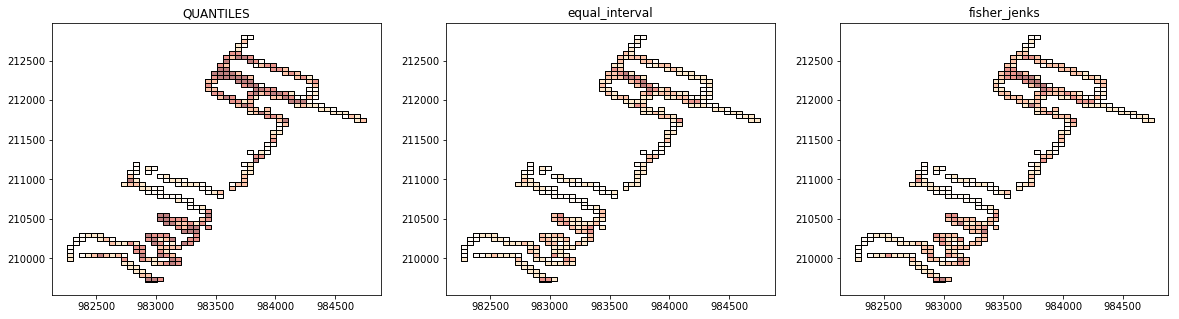

In [9]:
kw = dict(column='uni', k=30, colormap='OrRd')
f, (ax1, ax2, ax3) = pl.subplots(1,3,figsize=(20,5))
d_ax = {'ax1':ax1, 'ax2':ax2, 'ax3':ax3}
d_sch = {'ax1':'QUANTILES', 'ax2':'equal_interval', 'ax3':'fisher_jenks'}
for i in range(1,4,1):
    axi = 'ax'+str(i)
    grid_plot.plot(scheme=d_sch[axi], ax=d_ax[axi], **kw)
    d_ax[axi].set_title(d_sch[axi])

In [11]:
# fig, ax = pl.subplots(1,1,figsize==(5,5))
# grid_plot.plot(ax=ax, colormap='CMRmap', c=grid_plot.uni)
# mplleaflet.display(fig=ax.figure, crs=df.crs)

In [12]:
hp_target = pd.read_pickle("./hp_target.p")
hp_target.crs = from_epsg(2263)
hp_target['style'] = [{'fillColor': '#000000', 'weight': 1, 'color': 'tan'}] * len(hp_target)

In [13]:
m = folium.Map([40.743, -74], zoom_start=15, tiles='Cartodb dark_matter', crs='EPSG3857')
folium.GeoJson(grid_plot, overlay=False).add_to(m)
folium.GeoJson(hp_target, overlay=True).add_to(m)
m.add_child(colormap)
m

# To-Do
    - Carto / QGIS : HeatMap